# Cliffwalking-v0 悬崖寻路问题

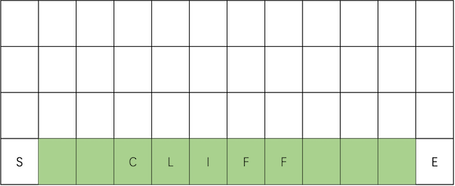

**问题背景**

在4*12的网格中，其中包括悬崖(3,1...10)，智能体从网格的左下角(3,0)出发，以网格的右下角(3,11)为终点，通过不断移动到达右下角终点位置。智能体每次可以选择上下左右，4个方向移动一步，每移动一步获得-1单位的奖励，同时，智能体移动受到以下限制：
1. 智能体不能移出4*12的网格范围；
2. 若智能体掉入悬崖，则会立刻回到起点重新开始移动，并且得到-100单位的奖励；
3. 当智能体移动到终点时，回合结束，该回合总奖励为各步奖励之和。

**动作action**
* 上:0
* 右:1
* 下:2
* 左:3

**状态state**

state$\in[0,47]$，表示4*12网格中的每个位置
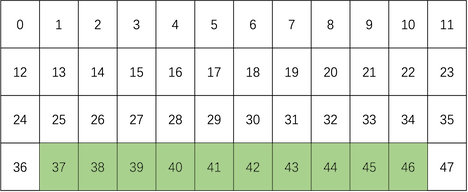

## 1. 实验环境配置
### 1.1 导入软件包

In [1]:
import gym
from gridworld import CliffWalkingWapper
import numpy as np
import random
import time
import matplotlib.pyplot as plt

### 1.2 Config

In [2]:
env = gym.make('CliffWalking-v0').unwrapped #载入env
episode = 100000 #最多epoch数

#初始化游戏最优得分
best_score = -1000 

#训练结束条件（得分100轮保持不变）
num_iteration = 100
lr = 0.7 #学习率
GAMMA = 0.99 #衰减因子
epsilon = 0.8

* **SARSA** 

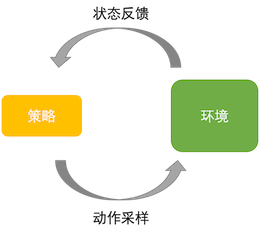

SARSA在更新Q表格和得到该状态下的action都采用$\epsilon -$贪心策略，是on-policy。

1. 动作action的$\epsilon -$贪心策略具体如下所示：

探索Exploration：当$\epsilon >= random\in[0,1]$，action采取随机动作；

深挖Exploitation：当$\epsilon < random\in[0,1]$，action利用Q表格得到。

2. Q表格的更新也适用$\epsilon -$贪心策略，具体更新如下式子：

            
$$Q(s_t,a_t)=Q(s_t,a_t)+\alpha [r+\gamma  Q(s_{t+1},a_{t+1})-Q(s_t,a_t)]$$

* **Q-learning**

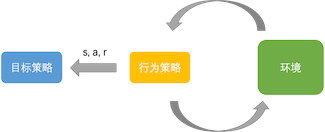

Q-learning是off-policy，在更新Q和选择action时采取不同的策略：动作action的选择采用与SARSA相同的方法——$\epsilon -$贪心策略，Q表格的更新则是通过选择最优action，具体式子如下：

$$Q(s_t,a_t)=Q(s_t,a_t)+\alpha [r+\gamma  max_{a^{\prime}}Q(s_{t+1},a^{\prime})-Q(s_t,a_t)]$$

**on-policy和off-policy的区别**关键在于 估计值函数Q 和 样本生成(action)的策略 是否相同。

* on-policy： 两个策略相同，目标策略（Q表格）与环境直接互动

* off-policy：目标策略通过行为策略进行更新，只有行为策略与环境直接互动。

* **Expected SARSA**

\begin{equation}
\begin{aligned}
Q\left(S_t, A_t\right) & \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \mathbb{E}\left[Q\left(S_{t+1}, A_{t+1}\right) \mid S_{t+1}\right]-Q\left(S_t, A_t\right)\right] \\
& \leftarrow Q\left(S_t, A_t\right)+\alpha\left[R_{t+1}+\gamma \sum_a \pi\left(a \mid S_{t+1}\right) Q\left(S_{t+1}, a\right)-Q\left(S_t, A_t\right)\right]
\end{aligned}
\end{equation}

\begin{equation}
\pi\left(a \mid S_{t+1}\right)= \begin{cases}\dfrac{\epsilon}{A_{num}} & \text {如果} \mathrm{a}=\text { Greedy Action } \\ 1-\epsilon+\frac{\epsilon}{A_{num}} & \text {如果} \mathrm{a}=\text { Non-Greedy Action }\end{cases}
\end{equation}

## 2 Qtable类

本封装类封装对Q表格的操作和访问，具体方法有以下5个：

```get_Q(self, state_code, action)``` ：获得当前状态下执行action后得到的Q

```get_best_action(self, state_code)``` ：获得当前状态下能够得到最大Q对应的动作

```get_max_Q(self, state_code)``` ：获得当前状态下能够获得的最大Q的值

```udpate_ql(self, *)``` ：使用qlearning的公式更新Qtable，采用最优的action

```udpate_sarsa(self, *)``` ：使用SARSA公式更新Qtable，采用$\epsilon-greedy$算法

In [3]:
class Qtable:
    def __init__(self, action_n=2, state_n=4):
        #可选动作数=4
        self.action_n = action_n
        #初始化Qtable
        self.table = np.zeros((int(state_n), int(action_n)))
    
    #更新Q表格
    #sarsa
    def update_sarsa(self, state_t, action, reward, lr, GAMMA, state_t1, max_q_next, epsilon):
        next_Q = self.get_Q(state_t1,self.get_epsilon_action(state_t1,epsilon))
        delta = reward + GAMMA*next_Q- self.table[state_t,action]
        self.table[state_t, action] += lr * delta
        return delta
    #qlearning
    def update_ql(self, state_t, action, reward, lr, GAMMA,state_t1, max_q_next):
        delta = reward + GAMMA*max_q_next - self.table[state_t,action]
        self.table[state_t, action] += lr * delta
        return delta
    
    #expected-sarsa
    def update_exp_sarsa(self, state_t, action, reward, lr, GAMMA, epsilon):
        policy = np.ones(self.action_n) * epsilon / self.action_n
        policy[np.argmax(self.table[state_t1])] = 1-epsilon + epsilon / self.action_n
        next_Q = np.dot(Q[state_t1],policy)
        delta = reward + GAMMA*next_Q
        self.table[state_t, action] += lr*delta
        return delta
    
    def get_epsilon_action(self,state,epsilon):
        # 返回基于epsion-greedy得到的action
        if np.random.random() <= epsilon:
            return np.random.choice([0,1])
        else:
            return self.get_best_action(state)
        
    #返回state的状态下执行动作action后得到的Q
    def get_Q(self, state, action):
        return self.table[state, action]
    
    #返回state状态下能够得到最大Q对应的动作
    def get_best_action(self, state):
        return np.argmax(self.table[state])
    
    #返回state状态能获得的最大Q值
    def get_max_Q(self, state):
        return float(np.max(self.table[state]))

## 3. environment类
本封装类主要对env返回的值进行处理，包含以下两个方法

```step(self,action)```: 采取动作action在env中运行一步，返回新的状态信息

In [4]:
class Environment:
    def __init__(self, env):
        self.env = env
    
    #采取动作action，游戏运行一步，并返回(状态、奖励、是否死亡、调试信息)
    def step(self, action):
        s_t, reward, done, *info = self.env.step(int(action))
        return s_t, reward, done, info[0]

## 5. train类
在Train封装类里进行模型的训练，包含以下两个方法：

```choose_action(self, epsilon, s_t_code)```：通过epsilon的值决定当前action基于探索还是深挖，即选择随机动作或基于q表格获得当前最优动作。

```train_model(self)```：训练模型

In [5]:
class Train:
    def __init__(self, episode, env, lr, GAMMA, best_score, num_iteration, epsilon):
        self.episode = episode
        self.env =env
        self.lr =lr
        self.GAMMA = GAMMA
        self.num_iteration = num_iteration
        self.best_score = best_score
        self.epsilon = epsilon
        
        self.Q_table = Qtable(action_n=env.action_space.n, 
                              state_n=env.observation_space.n)
        self.envir = Environment(env=self.env)
        
    def choose_action(self, epsilon, s_t):
        # action选择
        # 随着epoch增加epsilon变小，探索过程减少，逐渐收敛到最优
        if np.random.random() <= epsilon:
            # exploration，探索过程随机动作
            return self.env.action_space.sample()
        else:
            # exploitation， 挖掘过程选择能获得最大Q值的动作
            return self.Q_table.get_best_action(s_t)
    
    def train_model(self):
        #初始化
        n_iteration = self.num_iteration
        epsilon = self.epsilon
        last_epoch_reward = self.best_score
        #存储一些内容，便于之后分析
        step_reward_list=[]
        step_error_list=[]
        s_t_list=np.zeros(14)
        best_epoch_stay=0
        for e in range(self.episode):
            # 计时
            start = time.time()
            #epsilon随着epoch增加而减少
            epsilon = 0.9*epsilon
            # 初始化环境
            s_t= self.env.reset()[0]
            epoch_reward = 0
            s_t_list = np.hstack((s_t_list[1:],[s_t]))

            if e==0:
                # 第一轮随机从动作空间中选择一个动作
                action = self.env.action_space.sample()
            else:
                #后续按照epsilon-greedy选择
                action = self.choose_action(epsilon,s_t)
            s_t, reward, done, info = self.envir.step(action)
            epoch_reward += reward

            s_t_list = np.hstack((s_t_list[1:],[s_t]))
            best_epoch_stay += 1
            while not done:
                # 环境渲染画面
                self.env.render()

                #1. action选择：epsilon-greedy
                action = self.choose_action(epsilon, s_t)

                #2. env返回新的状态
                s_t1, reward, done, info = self.envir.step(action)

                epoch_reward += reward

                #3. 更新Q表格
                max_q_next = self.Q_table.get_max_Q(s_t1)

                #sarsa
#                 delta = self.Q_table.update_sarsa(state_t=s_t, action=action,
#                             reward=reward, lr=self.lr,
#                             GAMMA=self.GAMMA, state_t1=s_t1, max_q_next=max_q_next,epsilon=epsilon)

                #q-learning
                delta = self.Q_table.update_ql(state_t=s_t, action=action,
                            reward=reward, lr=self.lr,
                            GAMMA=self.GAMMA, state_t1=s_t1, max_q_next=max_q_next)
                #4. 更新当前状态s_t
                s_t = s_t1
                
                step_error_list.append(delta)
                s_t_list = np.hstack((s_t_list[1:],[s_t]))
            # 单个epoch计时结束
            end = time.time()
            step_reward_list.append(epoch_reward)
            #打印当前epoch信息
            print('Epoch:{0:d}'.format(e),
                 '  time:{0:.4f}'.format(end-start),
                 '  reward:{0:4f}'.format(epoch_reward))

            #判断是否更新最优reward值
            if epoch_reward > self.best_score:
                self.best_score = epoch_reward
                n_iteration = self.num_iteration
                best_epoch_stay = 0

            if epoch_reward == self.best_score:
                n_iteration -= 1

            #判断是否符合训练结束条件
            if(n_iteration <= 0):
                print('best_score: ',self.best_score)
                print('best_road: ',s_t_list)
                print('training successfully')
                np.save('t2_step_reward_'+str(e)+'.npy',np.array(step_reward_list))
                np.save('t2_step_error_'+str(e)+'.npy',np.array(step_error_list))
                break

## 6. 开始训练

In [6]:
#将config配置的参数放入train
train = Train(episode=episode, env=env, lr=lr, GAMMA=GAMMA, 
              best_score=best_score, num_iteration=num_iteration,
              epsilon=epsilon)
train.train_model()

Epoch:0   time:1.0862   reward:-5506.000000
Epoch:1   time:0.6191   reward:-3487.000000
Epoch:2   time:0.2983   reward:-1237.000000
Epoch:3   time:0.0331   reward:-29.000000
Epoch:4   time:0.2294   reward:-689.000000
Epoch:5   time:0.0618   reward:-149.000000
Epoch:6   time:0.0932   reward:-276.000000
Epoch:7   time:0.0489   reward:-240.000000
Epoch:8   time:0.0741   reward:-162.000000
Epoch:9   time:0.1438   reward:-617.000000
Epoch:10   time:0.0356   reward:-31.000000
Epoch:11   time:0.0167   reward:-15.000000
Epoch:12   time:0.1654   reward:-438.000000
Epoch:13   time:0.0304   reward:-125.000000
Epoch:14   time:0.0322   reward:-28.000000
Epoch:15   time:0.0202   reward:-18.000000
Epoch:16   time:0.0486   reward:-240.000000
Epoch:17   time:0.0343   reward:-30.000000
Epoch:18   time:0.0438   reward:-137.000000
Epoch:19   time:0.0429   reward:-235.000000
Epoch:20   time:0.0268   reward:-23.000000
Epoch:21   time:0.0166   reward:-15.000000
Epoch:22   time:0.0202   reward:-18.000000
Epoc

## 7. 打印训练过程

训练时每局游戏reward-epoch


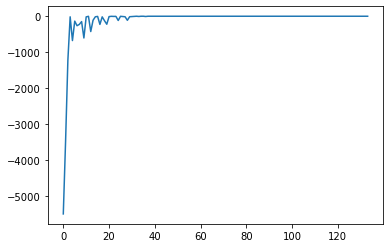

Q表格更新时的误差量-更新次数


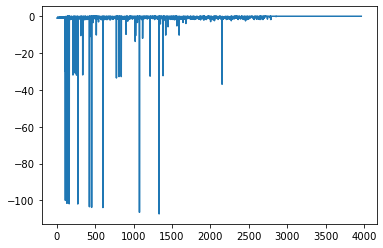

In [7]:
#加载文件
step_reward_list = np.load('/Users/ll/code/enforcement/t2_step_reward_133.npy')
step_error_list = np.load('/Users/ll/code/enforcement/t2_step_error_133.npy')
# print pic
print("训练时每局游戏reward-epoch")
plt.plot(step_reward_list)
plt.show()
print("Q表格更新时的误差量-更新次数")
plt.plot(step_error_list)
plt.show()